## Paczki

In [7]:
TRAIN_IMG_DIR = '../../imagenet/colorized_imagenet/colorized_imagenet_demo/train'
VAL_IMG_DIR = '../../imagenet/colorized_imagenet/colorized_imagenet_demo/val'
CHECKPOINT_PATH = '/tmp/checkpoints'
CLASSES_PATH = '../data/used_ab_pairs.txt'
MODEL_PATH = '/tmp'
SAMPLE_SIZE = -1
BATCH_SIZE = 16
LEARNING_RATE = 1e-2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

Podstawowy model do kolorowania

In [2]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from pytorch_lightning.callbacks import ModelCheckpoint
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.notebook import tqdm

## Zbiór danych - wstępna analiza

In [108]:
class InitialTestDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))
        self.label_files = sorted(os.listdir(label_dir))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        
        label = Image.open(label_path).convert('RGB') # to ensure RGB format
        label_np = np.array(label)
        label_lab = cv2.cvtColor(label_np, cv2.COLOR_RGB2LAB)
        l = label_lab[:, :, 0]  # Lightness channel
        ab = label_lab[:, :, 1:]  # AB channels

        l_tensor = torch.tensor(l, dtype=torch.float32).unsqueeze(0)  # Shape: [1, H, W]
        ab_tensor = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1)  # Shape: [2, H, W]

        

        input_l = l_tensor
        target = ab_tensor

        return input_l, target

In [208]:
def combine_l_ab(l : torch.Tensor, ab : torch.Tensor, ab_pairs_classes) -> np.ndarray:

    # if not batched then add batch dimension
    if l.ndim == 3:
        l = l.unsqueeze(0)
        ab = ab.unsqueeze(0)

    # ab is index for NUM_CLASSES bins

    lab_image_tensor = torch.cat((l, ab), dim=1)  # Shape: [1, 3, H, W]

    lab_image_np = lab_image_tensor.squeeze(0).numpy().transpose(1, 2, 0)

    # **Fix LAB ranges for OpenCV**
    # Ensure L is in [0, 255]
    lab_image_np[:, :, 0] = np.clip(lab_image_np[:, :, 0], 0, 255)

    # Ensure A and B are centered around 128 and within [0, 255]
    lab_image_np[:, :, 1:] = np.clip(lab_image_np[:, :, 1:], 0, 255)

    # Convert LAB back to RGB
    rgb_image = cv2.cvtColor(lab_image_np.astype(np.uint8), cv2.COLOR_LAB2RGB)

    return rgb_image

In [112]:
if SAMPLE_SIZE == -1:
    test_train_dataset = InitialTestDataset(
        img_dir=f'{TRAIN_IMG_DIR}/img',
        label_dir=f'{TRAIN_IMG_DIR}/label',
    )
    test_val_dataset = InitialTestDataset(
        img_dir=f'{VAL_IMG_DIR}/img',
        label_dir=f'{VAL_IMG_DIR}/label',
    )
else:
    test_train_dataset = torch.utils.data.Subset(
        InitialTestDataset(
            img_dir=f'{TRAIN_IMG_DIR}/img',
            label_dir=f'{TRAIN_IMG_DIR}/label',
        ),
        indices = range(SAMPLE_SIZE),
    )
    test_val_dataset = torch.utils.data.Subset(
        InitialTestDataset(
            img_dir=f'{VAL_IMG_DIR}/img',
            label_dir=f'{VAL_IMG_DIR}/label',
        ),
        indices = range(SAMPLE_SIZE // 10),
    )

## Kolory

In [4]:
AB_NORM = 255.0

In [49]:
def generate_ab_pairs(grid_size=10, luminance=50):
    """Generate 313 quantized ab pairs that are within the RGB gamut."""

    a_range = np.arange(0, AB_NORM, grid_size)
    b_range = np.arange(0, AB_NORM, grid_size)
    ab_grid = np.array(np.meshgrid(a_range, b_range)).T.reshape(-1, 2)

    valid_ab = set()

    for ab in ab_grid:
        a,b = ab
        lab_color = np.array([[luminance, a, b]], dtype=np.float32)

        rgb_color = cv2.cvtColor(lab_color[None, :, :], cv2.COLOR_LAB2RGB)[0, 0, :]

        if np.all(rgb_color >= 0) and np.all(rgb_color <= 1):
            valid_ab.add((a, b))
    
    return valid_ab

In [5]:
def get_nearest_bin(ab, grid_size=10):
    """Get the nearest ab bin to the given ab value.
    ab: Tuple of (a, b) values.
    """
    a, b = ab

    nearest_a = round(a / grid_size) * grid_size
    nearest_b = round(b / grid_size) * grid_size

    return (nearest_a, nearest_b)

In [53]:
from collections import Counter

In [54]:
ab_pairs = generate_ab_pairs(grid_size=10)
ab_pair_counter = Counter()

for _, target in tqdm(val_dataset):
    ab_values = target.permute(1, 2, 0).numpy()
    ab_values = ab_values.reshape(-1, 2)

    nearest_bins = map(get_nearest_bin, ab_values)
    ab_pair_counter.update(nearest_bins)

  0%|          | 0/4991 [00:00<?, ?it/s]

In [61]:
most_common_256 = ab_pair_counter.most_common(256)

In [62]:
len(
    most_common_256
)

256

In [57]:
used_ab_pairs = [ab_pair for ab_pair, _ in most_common_256]

# save used_ab_pairs as txt, do not overwrite

if not os.path.exists(CLASSES_PATH):
    with open(CLASSES_PATH, 'w') as f:
        for ab_pair in used_ab_pairs:
            f.write(f'{ab_pair[0]},{ab_pair[1]}\n')

In [8]:
used_ab_pairs = []
with open(CLASSES_PATH, 'r') as f:
    for line in f:
        a, b = line.strip().split(',')
        used_ab_pairs.append((int(a), int(b)))

In [9]:
NUM_CLASSES = len(used_ab_pairs)

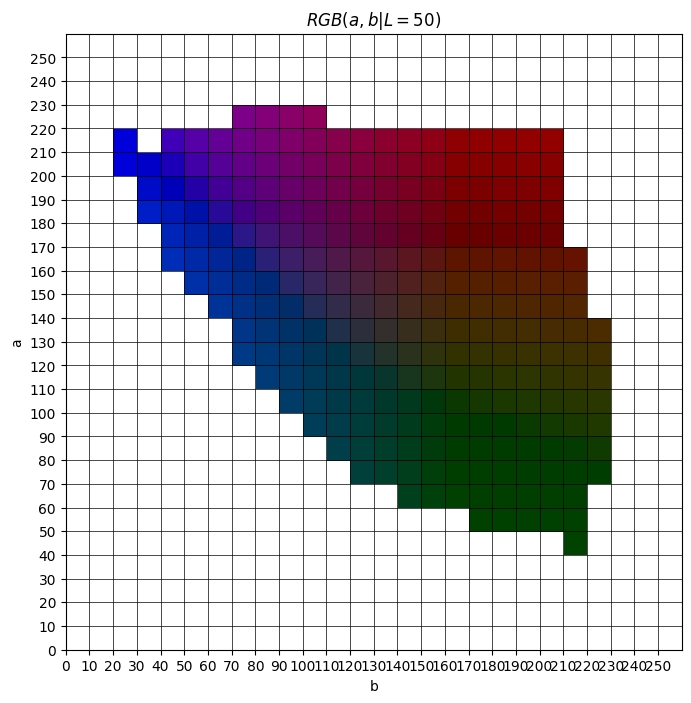

In [10]:
def plot_ab_color_map_matshow(ab_pairs, L=50, grid_size=10):
    """Plot a 2D color map for the ab space using the provided ab pairs with matshow."""

    a_range = np.arange(0, AB_NORM, grid_size)
    b_range = np.arange(0, AB_NORM, grid_size)
    ab_grid = np.array(np.meshgrid(a_range, b_range)).T.reshape(-1, 2)

    color_grid = {
        (a, b): [255, 255, 255] for a, b in ab_grid
    }
    
    for ab in ab_pairs:
        a, b = ab

        lab_color = np.array([L, a, b], dtype=np.uint8)
        
        # ensure L is in [0, 255]
        lab_color[0] = np.clip(lab_color[0], 0, 255)

        # Ensure A and B are centered around 128 and within [0, 255]
        lab_color[1:] = np.clip(lab_color[1:], 0, 255)

        rgb_color = cv2.cvtColor(
            lab_color[None, None, :].astype(np.uint8),
            cv2.COLOR_LAB2RGB
        )

        # check if the color is within the RGB gamut
        if np.all(rgb_color >= 0) and np.all(rgb_color <= 255):
            # rgb_color = (rgb_color * 255).astype(np.uint8)[0, 0, :]
            color_grid[(a, b)] = rgb_color

        color_grid[(a, b)] = rgb_color

    len_grid_range = len(a_range)

    rgb_array = np.full((len_grid_range, len_grid_range, 3), 255, dtype=np.uint8)
    for i, a in enumerate(a_range):
        for j, b in enumerate(b_range):
            rgb_array[i, j, :] = color_grid[(a, b)]


    plt.figure(figsize=(8, 8))
    plt.imshow(
        rgb_array,
        origin="lower",
        extent=(0, len_grid_range, 0, len_grid_range),
    )
    plt.xlabel("b")
    plt.ylabel("a")
    plt.title(r"$RGB(a, b | L=50)$")

    plt.grid(color="black", linestyle="-", linewidth=0.5)

    tick_positions = np.arange(0, len_grid_range, 1).astype(np.uint8)
    tick_labels = np.arange(0, AB_NORM, grid_size).astype(np.uint8)

    plt.xticks(tick_positions, labels=tick_labels)
    plt.yticks(tick_positions, labels=tick_labels)

# plot_ab_color_map_matshow(ab_pairs)
plot_ab_color_map_matshow(used_ab_pairs)

In [11]:
def one_hot_encode_ab_pairs(ab_tensor, used_ab_pairs, grid_size=10):
    """
    Convert ab values to one-hot encoded tensor based on the closest used_ab_pairs.

    Args:
        ab_tensor (torch.Tensor): Tensor of shape (batch, h, w, 2) containing ab values.
        used_ab_pairs (list): List of used ab pairs.
        grid_size (int): Grid size for quantization.

    Returns:
        torch.Tensor: One-hot encoded tensor of shape (batch, h, w, len(used_ab_pairs)).
    """
    batch, h, w, _ = ab_tensor.shape
    num_classes = len(used_ab_pairs)

    assert ab_tensor.shape[3] == 2, "ab_tensor must have 2 channels."
    assert num_classes == NUM_CLASSES, "Number of classes must match the number of used ab pairs."
    assert h == IMAGE_HEIGHT and w == IMAGE_WIDTH, "Height and width must match the image dimensions."
    
    # Create a tensor to hold the one-hot encoded values
    one_hot_tensor = torch.zeros((batch, h, w, num_classes), dtype=torch.float32)

    # Convert used_ab_pairs to a list of tuples for easy indexing
    used_ab_pairs_list = list(used_ab_pairs)

    # Create a dictionary to map ab pairs to their indices
    ab_pair_to_index = {ab_pair: idx for idx, ab_pair in enumerate(used_ab_pairs_list)}

    # print(ab_tensor.shape)

    # Iterate over each pixel in the batch
    for b in range(batch):
        for i in range(h):
            for j in range(w):
                ab_value = ab_tensor[b, i, j].numpy()
                nearest_bin = get_nearest_bin(ab_value, grid_size)
                if nearest_bin in ab_pair_to_index:
                    one_hot_tensor[b, i, j, ab_pair_to_index[nearest_bin]] = 1.0
                else:
                    raise ValueError(f"Nearest bin not found: {nearest_bin}")

    assert torch.all(one_hot_tensor.sum(dim=-1) == 1.0), "One-hot tensor is not correctly encoded."
    
    return one_hot_tensor


In [ ]:
_, y = next(iter(DataLoader(test_train_dataset, batch_size=1)))
test_y_onehot_map = one_hot_encode_ab_pairs(y.permute(0, 2, 3, 1), used_ab_pairs)

In [135]:
_, y = next(iter(DataLoader(train_dataset, batch_size=1)))

print(y.shape)

assert y.shape == (1, NUM_CLASSES, IMAGE_HEIGHT, IMAGE_WIDTH), "Target shape is incorrect."

torch.Size([1, 256, 256, 2])
torch.Size([1, 256, 256, 256])


## Wagi do rebalansingu

In [368]:
# save  ab_pair_counter

ab_pair_counter_path = '../data/ab_pair_counter.txt'

if not os.path.exists(ab_pair_counter_path):
    with open(ab_pair_counter_path, 'w') as f:
        for ab_pair, count in ab_pair_counter.items():
            f.write(f'{ab_pair[0]},{ab_pair[1]},{count}\n')

In [324]:
from scipy.ndimage import gaussian_filter1d

In [329]:
def compute_weights_from_pairs(used_ab_pairs, ab_pair_counter, sigma=5, lambda_factor=0.5):
    """
    Compute class-rebalancing weights from used_ab_pairs and ab_pair_counter.

    Args:
        used_ab_pairs (list): List of quantized ab pairs for each class.
        ab_pair_counter (Counter): Counter with quantized ab pair counts.
        sigma (float): Standard deviation for Gaussian smoothing.
        lambda_factor (float): Mixing factor for uniform distribution.

    Returns:
        torch.Tensor: Class weights of shape [num_classes].
    """
    num_classes = len(used_ab_pairs)

    # Initialize counts for each class
    class_counts = np.zeros(num_classes, dtype=np.float32)

    # Populate counts using ab_pair_counter
    for idx, ab_pair in enumerate(used_ab_pairs):
        class_counts[idx] = ab_pair_counter.get(ab_pair, 0)

    # Compute empirical probabilities
    total_count = class_counts.sum()
    empirical_probs = class_counts / total_count if total_count > 0 else class_counts

    # Smooth the empirical probabilities using Gaussian filtering
    smoothed_probs = gaussian_filter1d(empirical_probs, sigma=sigma)

    # Mix with uniform distribution
    uniform_probs = np.ones_like(smoothed_probs) / num_classes
    mixed_probs = (1 - lambda_factor) * smoothed_probs + lambda_factor * uniform_probs

    # Compute weights (reciprocal of the mixed probabilities)
    weights = 1 / (mixed_probs + 1e-10)  # Avoid division by zero

    # Normalize weights so their expectation is 1
    normalized_weights = weights / (weights @ empirical_probs)

    return torch.tensor(normalized_weights, dtype=torch.float32)

weights = compute_weights_from_pairs(used_ab_pairs, ab_pair_counter)

In [331]:
rebalancing_weights = weights

In [13]:
WEIGHTS_PATH = '../data/rebalancing_weights.txt'

In [367]:
# save rebalancing_weights as txt, do not overwrite
if not os.path.exists(WEIGHTS_PATH):
    with open(WEIGHTS_PATH, 'w') as f:
        for weight in rebalancing_weights:
            f.write(f'{weight}\n')

In [28]:
rebalancing_weights = []
with open(WEIGHTS_PATH, 'r') as f:
    for line in f:
        rebalancing_weights.append(float(line.strip()))

rebalancing_weights = torch.tensor(rebalancing_weights, dtype=torch.float32)

## Zbiór danych treningowych

In [189]:
class AutoColorizationDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))
        self.label_files = sorted(os.listdir(label_dir))
        self.num_classes = len(used_ab_pairs)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        
        label = Image.open(label_path).convert('RGB') # to ensure RGB format
        label_np = np.array(label)
        label_lab = cv2.cvtColor(label_np, cv2.COLOR_RGB2LAB)
        l = label_lab[:, :, 0]  # Lightness channel
        ab = label_lab[:, :, 1:]  # AB channels

        ab = torch.tensor(ab, dtype=torch.float32)#.permute(2, 0, 1)
        # print(ab.shape)

        ab_onehot = one_hot_encode_ab_pairs(ab[None, :, :, :], used_ab_pairs).squeeze(0)

        l_tensor = torch.tensor(l, dtype=torch.float32).unsqueeze(0)  # Shape: [1, H, W]
        # ab_tensor = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1)  # Shape: [2, H, W]

        ab_onehot_tensor = ab_onehot.permute(2, 0, 1) # Shape [NUM_CLASSES, H, W]

        assert ab_onehot_tensor.shape == (self.num_classes, IMAGE_HEIGHT, IMAGE_WIDTH), "One-hot tensor shape is incorrect."

        onehot_index = ab_onehot_tensor.argmax(dim=0)
        
        input_l = l_tensor
        target = onehot_index

        return input_l, target

In [15]:
class AutoColorizationDatasetFromTorchFiles(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))
        self.label_files = sorted(os.listdir(label_dir))
        self.num_classes = len(used_ab_pairs)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        
        input_l = torch.load(img_path, weights_only=True)
        target = torch.load(label_path, weights_only=True)

        assert input_l.shape == (1, IMAGE_HEIGHT, IMAGE_WIDTH), "Input L shape is incorrect."
        assert target.shape == (IMAGE_HEIGHT, IMAGE_WIDTH), "Target shape is incorrect."

        return input_l, target

In [16]:
TARGET_DIR = '../../imagenet/colorization_dataset_imagenet/'
TARGET_TRAIN_DIR = os.path.join(TARGET_DIR, 'train')
TARGET_VAL_DIR = os.path.join(TARGET_DIR, 'val')

train_dataset = AutoColorizationDatasetFromTorchFiles(
    img_dir=f'{TARGET_TRAIN_DIR}/img',
    label_dir=f'{TARGET_TRAIN_DIR}/label',
)
val_dataset = AutoColorizationDatasetFromTorchFiles(
    img_dir=f'{TARGET_VAL_DIR}/img',
    label_dir=f'{TARGET_VAL_DIR}/label',
)

In [339]:
X, y = next(iter(DataLoader(train_dataset, batch_size=1)))

In [163]:
# train_dataset = AutoColorizationDataset(
#     img_dir=f'{TRAIN_IMG_DIR}/img',
#     label_dir=f'{TRAIN_IMG_DIR}/label',
# )
# val_dataset = AutoColorizationDataset(
#     img_dir=f'{VAL_IMG_DIR}/img',
#     label_dir=f'{VAL_IMG_DIR}/label',
# )

## Modele

In [26]:
class BaseColor(nn.Module):
    """Base class for color normalization and unnormalization."""
    def __init__(self):
        super(BaseColor, self).__init__()
        self.l_cent = 50.0
        self.l_norm = 100.0
        self.ab_norm = 110.0

    def normalize_l(self, in_l):
        return (in_l - self.l_cent) / self.l_norm

    def unnormalize_l(self, in_l):
        return in_l * self.l_norm + self.l_cent

    def normalize_ab(self, in_ab):
        return in_ab / self.ab_norm

    def unnormalize_ab(self, in_ab):
        return in_ab * self.ab_norm
    
    def quantize_ab(self, in_ab):
        # divide ab space, quantize into NUM_CLASSES bins
        return torch.round(in_ab / 10.0)

class ECCVGenerator(BaseColor):
    """Colorization model based on ECCV16 architecture."""
    def __init__(self, norm_layer=nn.BatchNorm2d, num_classes=529):
        super(ECCVGenerator, self).__init__()

        def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, extra_layer=False):
            return [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=True),
                nn.ReLU(inplace=True),
            ] if not extra_layer else [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, dilation, bias=True),
                nn.ReLU(inplace=True),
            ]

        def norm_relu_block(channels):
            return [
                nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1, bias=True),
                nn.ReLU(inplace=True),
                norm_layer(channels),
            ]
        
        self.encoder1 = nn.Sequential(*conv_block(1, 64), *norm_relu_block(64))
        self.encoder2 = nn.Sequential(*conv_block(64, 128), *norm_relu_block(128))
        self.encoder3 = nn.Sequential(*conv_block(128, 256, extra_layer=True), *norm_relu_block(256))
        self.encoder4 = nn.Sequential(*conv_block(256, 512, extra_layer=True), *norm_relu_block(512))
        self.encoder5 = nn.Sequential(*conv_block(512, 512, extra_layer=True, dilation=2, padding=2), *norm_relu_block(512))

        self.bottleneck = nn.Sequential(*conv_block(512, 512, dilation=2, padding=2, extra_layer=True), *norm_relu_block(512))

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(inplace=True),
            *conv_block(256, 256),
            *conv_block(256, 256),
        )

        # multinomial classification into 313 bins of ab color space
        # self.decoder2 = nn.Sequential(
        #     *conv_block(256, 313, kernel_size=1, stride=1, padding=0),
        # )

        self.decoder2 = nn.Sequential(
            *conv_block(256, NUM_CLASSES, kernel_size=1, stride=1, padding=0),
        )


        self.softmax = nn.Softmax(dim=1)
        # self.model_output = nn.Conv2d(313, 2, kernel_size=1, stride=1, padding=0, bias=False)        
        self.upsample4 = nn.Upsample(scale_factor=32, mode='bilinear') # TODO check changed from 4 to 32
        
    def forward(self, input_l):
        """Forward pass of the model.

        Args:
            input_l: L channel of the input image.

        Returns:
            Colorized ab channels.
        """
        # print('Forward pass')
        # print(f'before reshape {input_l.shape}')

        # print(f'normalized {self.normalize_l(input_l).shape}')

        conv1 = self.encoder1(self.normalize_l(input_l))
        conv2 = self.encoder2(conv1)
        conv3 = self.encoder3(conv2)
        conv4 = self.encoder4(conv3)
        conv5 = self.encoder5(conv4)
        bottleneck = self.bottleneck(conv5)
        decv1 = self.decoder1(bottleneck)
        decv2 = self.decoder2(decv1)
        # out = self.model_output(
        #     self.softmax(decv2)
        # )
        out = self.softmax(decv2)
        # print(f'Forward End out {out.shape} ')

        # print(f'returning {self.unnormalize_ab(self.upsample4(out)).shape}')
        return self.unnormalize_ab(
            self.upsample4(out)
        )

In [168]:
X, y = next(iter(DataLoader(train_dataset, batch_size=1)))

In [169]:
test_model = ECCVGenerator()
out = test_model(X)

## Pytorch Lightning

In [78]:
class ECCV_LM(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super(ECCV_LM, self).__init__()
        self.model = ECCVGenerator()
        # self.criterion = nn.MSELoss()
        # self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.CrossEntropyLoss(weight=rebalancing_weights)
        self.learning_rate = learning_rate

    def forward(self, input_l):
        return self.model(input_l)

    def training_step(self, batch, batch_idx):
        input_l, target_ab = batch

        # print(f'training step')
        # input_l = input_l.squeeze(1)  # Remove the additional dimension if it exists
        # print(f'{input_l.shape=}')
        # print(f'{target_ab.shape=}')

        pred_ab = self(input_l)

        batch_size = len(batch)

        # print(f'{pred_ab.shape=}')
        # print(f'{batch_size=}')

        # assert pred_ab.shape == (NUM_CLASSES, IMAGE_HEIGHT, IMAGE_WIDTH), "Prediction shape is incorrect."
        # assert target_ab.shape == (batch_size, IMAGE_HEIGHT, IMAGE_WIDTH), "Target shape is incorrect."

        loss = self.criterion(pred_ab, target_ab)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_l, target_ab = batch
        
        # print(f'validation step')
        # input_l = input_l.squeeze(1)
        # print(f'{input_l.shape=}')
        # print(f'{target_ab.shape=}')

        pred_ab = self(input_l)
        # print(f'{pred_ab.shape=}')
        loss = self.criterion(pred_ab, target_ab)
        self.log('val_loss', loss, prog_bar=True)
        # print(f'Step {batch_idx} Val loss {loss}')

    def test_step(self, batch, batch_idx):
        input_l, target_ab = batch
        
        # print(f'test step')
        # input_l = input_l.squeeze(1)
        # print(f'{input_l.shape=}')
        # print(f'{target_ab.shape=}')

        pred_ab = self(input_l)
        loss = self.criterion(pred_ab, target_ab)
        self.log('test_loss', loss)
        # print(f'Step {batch_idx} Test loss {loss}')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer


## Varia

In [11]:
# label = Image.open(
#     '/media/jacek/pliki/uczelnia/12-semestr/gsn/projekt/imagenet/colorized_imagenet/colorized_imagenet_demo/val/label/000005.JPEG'
# )
# # label to tensor
# label_np = np.array(label)


# lab_image = cv2.cvtColor(label_np, cv2.COLOR_RGB2LAB)

# lab_image_tensor = torch.tensor(lab_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

# l_tensor = lab_image_tensor[:, 0, :, :].unsqueeze(0)
# ab_tensor = lab_image_tensor[:, 1:, :, :]

# lab_recon_tensor = torch.cat((l_tensor, ab_tensor), dim=1)
# lab_recon_tensor = lab_recon_tensor.squeeze(0)
# lab_recon_np = lab_recon_tensor.numpy().transpose(1, 2, 0)


# rgb = cv2.cvtColor(lab_recon_np, cv2.COLOR_LAB2RGB)
# rgb_np = rgb

In [12]:
# from PIL import Image
# import numpy as np
# import cv2
# import torch

# # Load image
# label = Image.open(
#     '/media/jacek/pliki/uczelnia/12-semestr/gsn/projekt/imagenet/colorized_imagenet/colorized_imagenet_demo/val/label/000005.JPEG'
# )

# # Convert label to NumPy array
# label_np = np.array(label)

# # Convert label to LAB color space
# lab_image = cv2.cvtColor(label_np, cv2.COLOR_RGB2LAB)

# lab_image = lab_image.T
# lightness = lab_image[0]
# ab = lab_image[1:]
# lightness = torch.tensor(lightness, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
# ab = torch.tensor(ab, dtype=torch.float32).unsqueeze(0)

# lab_image_tensor = torch.cat((lightness, ab), dim=1)
# lab_image_tensor = lab_image_tensor.squeeze(0)
# lab_image_np = lab_image_tensor.numpy().transpose(1, 2, 0)

# rgb_image = cv2.cvtColor(lab_image_np, cv2.COLOR_LAB2RGB)

# plt.imshow(rgb_image)

In [13]:
# from PIL import Image
# import numpy as np
# import cv2
# import torch
# import matplotlib.pyplot as plt

# # Load image
# label = Image.open(
#     '/media/jacek/pliki/uczelnia/12-semestr/gsn/projekt/imagenet/colorized_imagenet/colorized_imagenet_demo/val/label/000005.JPEG'
# )

# # Convert label to NumPy array
# label_np = np.array(label)

# # Convert label to LAB color space
# lab_image = cv2.cvtColor(label_np, cv2.COLOR_RGB2LAB)

# # Separate L and AB channels
# l = lab_image[:, :, 0]  # Lightness channel
# ab = lab_image[:, :, 1:]  # AB channels

# # Convert to tensors
# l_tensor = torch.tensor(l, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
# ab_tensor = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Shape: [1, 2, H, W]

# # Combine L and AB channels
# lab_image_tensor = torch.cat((l_tensor, ab_tensor), dim=1)  # Shape: [1, 3, H, W]

# # Convert back to NumPy array
# lab_image_np = lab_image_tensor.squeeze(0).numpy().transpose(1, 2, 0)

# # Ensure LAB values are within valid ranges
# lab_image_np[:, :, 0] = np.clip(lab_image_np[:, :, 0], 0, 100)
# lab_image_np[:, :, 1:] = np.clip(lab_image_np[:, :, 1:], -128, 127)

# # Convert back to RGB
# rgb_image = cv2.cvtColor(lab_image_np.astype(np.uint8), cv2.COLOR_LAB2RGB)

# # Display the image
# plt.imshow(rgb_image)
# plt.axis('off')
# plt.show()

In [14]:
# from PIL import Image
# import numpy as np
# import cv2
# import torch
# import matplotlib.pyplot as plt

# # Load the image and ensure RGB format
# label = Image.open(
#     '/media/jacek/pliki/uczelnia/12-semestr/gsn/projekt/imagenet/colorized_imagenet/colorized_imagenet_demo/val/label/000005.JPEG'
# ).convert('RGB')

# label_np = np.array(label)

# lab_image = cv2.cvtColor(label_np, cv2.COLOR_RGB2LAB)

# l = lab_image[:, :, 0]  # Lightness channel
# ab = lab_image[:, :, 1:]  # AB channels

# l_tensor = torch.tensor(l, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
# ab_tensor = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Shape: [1, 2, H, W]

# lab_image_tensor = torch.cat((l_tensor, ab_tensor), dim=1)  # Shape: [1, 3, H, W]

# lab_image_np = lab_image_tensor.squeeze(0).numpy().transpose(1, 2, 0)

# # **Fix LAB ranges for OpenCV**
# # Ensure L is in [0, 255]
# lab_image_np[:, :, 0] = np.clip(lab_image_np[:, :, 0], 0, 255)

# # Ensure A and B are centered around 128 and within [0, 255]
# lab_image_np[:, :, 1:] = np.clip(lab_image_np[:, :, 1:], 0, 255)

# # Convert LAB back to RGB
# rgb_image = cv2.cvtColor(lab_image_np.astype(np.uint8), cv2.COLOR_LAB2RGB)

# # Display the reconstructed image
# plt.imshow(rgb_image)
# plt.axis('off')
# plt.show()


## Trening

In [70]:
# SAMPLE_SIZE = 100
BATCH_SIZE = 16

In [79]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=3)

In [80]:
model = ECCV_LM(learning_rate=LEARNING_RATE)

In [20]:
model_path = f'{MODEL_PATH}/eccv_model_size_{SAMPLE_SIZE}.pt'

In [22]:
model = ECCV_LM.load_from_checkpoint('/tmp/eccv_model_size_100.pt')

KeyError: 'pytorch-lightning_version'

In [85]:
torch.cuda.reset_accumulated_memory_stats(device=None)
torch.cuda.reset_peak_memory_stats(device=None)
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.reset_max_memory_cached(device=None)


/media/jacek/pliki/uczelnia/12-semestr/gsn/gsn_env/lib/python3.12/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/media/jacek/pliki/uczelnia/12-semestr/gsn/gsn_env/lib/python3.12/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [82]:
torch.cuda.empty_cache()

In [373]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [376]:
X, y = next(iter(train_loader))

In [81]:
checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINT_PATH,
    filename="{epoch}-{val_loss:.2f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    save_last=True
)

trainer = pl.Trainer(
                    max_epochs=1,
                    precision=16,
                    callbacks=[checkpoint_callback]
                    )
trainer.fit(model, train_loader, val_loader)

/media/jacek/pliki/uczelnia/12-semestr/gsn/gsn_env/lib/python3.12/site-packages/lightning_fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/media/jacek/pliki/uczelnia/12-semestr/gsn/gsn_env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ECCVGenerator    | 25.1 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.561   Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 3.93 GiB of which 799.00 MiB is free. Including non-PyTorch memory, this process has 2.61 GiB memory in use. Of the allocated memory 2.43 GiB is allocated by PyTorch, and 136.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [62]:
trainer.test(model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │            nan            │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': nan}]

In [381]:
# saving

Model saved to /tmp/eccv_model_size_100.pt


## Trening - Varia

In [19]:
trainer = pl.Trainer(
                    max_epochs=3,
                    callbacks=[checkpoint_callback]
                    )
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | model     | ECCVGenerator | 25.2 M | train
1 | criterion | MSELoss       | 0      | train
----------------------------------------------------
25.2 M    Trainable params
0         Non-trainable params
25.2 M    Total params
100.622   Total estimated model params size (MB)
59        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [61]:
from pytorch_lightning.tuner.tuning import Tuner

In [62]:
trainer = pl.Trainer(
                    max_epochs=1,
                    )

tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 63 steps due to diverging loss.
Learning rate set to 7.585775750291837e-08
Restoring states from the checkpoint path at /media/jacek/pliki/uczelnia/12-semestr/gsn/projekt/picturecolorizing/notebooks/.lr_find_e157098a-51e1-4b5e-a048-902b185c0b05.ckpt
Restored all states from the checkpoint at /media/jacek/pliki/uczelnia/12-semestr/gsn/projekt/picturecolorizing/notebooks/.lr_find_e157098a-51e1-4b5e-a048-902b185c0b05.ckpt


/tmp/ipykernel_157137/3741487882.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Suggested Learning Rate: 7.585775750291837e-08


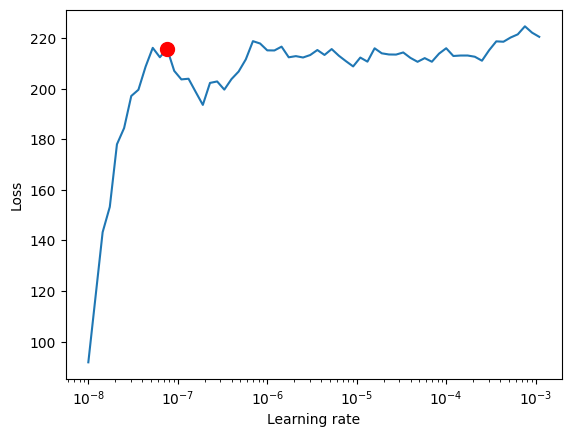

In [63]:
# Plot the learning rate finder results
fig = lr_finder.plot(suggest=True)
fig.show()

# Get the suggested learning rate
suggested_lr = lr_finder.suggestion()
print(f"Suggested Learning Rate: {suggested_lr}")

model.hparams.lr = suggested_lr

In [67]:
trainer = pl.Trainer(
                    max_epochs=1,
                    )
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params | Mode
---------------------------------------------------
0 | model     | ECCVGenerator | 25.2 M | eval
1 | criterion | MSELoss       | 0      | eval
---------------------------------------------------
25.2 M    Trainable params
0         Non-trainable params
25.2 M    Total params
100.622   Total estimated model params size (MB)
0         Modules in train mode
59        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## Wizualizacja

In [63]:
def combine_l_ab(l : torch.Tensor, ab : torch.Tensor) -> np.ndarray:
    """Returns RGB image from LAB lightness and AB channels."""

    # if not batched then add batch dimension
    # while l.ndim < 4:
    #     l = l.unsqueeze(0)
    # while ab.ndim < 4:
    #     ab = ab.unsqueeze(0)

    # ab is index for NUM_CLASSES bins
    print(l.shape)
    print(ab.shape)

    lab_image_tensor = torch.cat((l, ab), dim=1)  # Shape: [1, 3, H, W]

    lab_image_np = lab_image_tensor.squeeze(0).numpy().transpose(1, 2, 0)

    assert lab_image_np.shape == (IMAGE_HEIGHT, IMAGE_WIDTH, 3), f"LAB image shape {lab_image_np.shape} is incorrect"

    # **Fix LAB ranges for OpenCV**
    # Ensure L is in [0, 255]
    lab_image_np[:, :, 0] = np.clip(lab_image_np[:, :, 0], 0, 255)

    # Ensure A and B are centered around 128 and within [0, 255]
    lab_image_np[:, :, 1:] = np.clip(lab_image_np[:, :, 1:], 0, 255)

    # Convert LAB back to RGB
    rgb_image = cv2.cvtColor(lab_image_np.astype(np.uint8), cv2.COLOR_LAB2RGB)

    return rgb_image

In [64]:
def convert_index_tensor_to_ab_tensor(index_tensor : torch.Tensor, used_ab_pairs) -> torch.Tensor:
    assert index_tensor.ndim == 2, "Index tensor must be 2D."
    ab = torch.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, 2), dtype=torch.float32)
    for i in range(IMAGE_HEIGHT):
        for j in range(IMAGE_WIDTH):
            ab[0, i, j] = torch.tensor(used_ab_pairs[index_tensor[i, j]], dtype=torch.float32)
    assert ab.shape == (1, IMAGE_HEIGHT, IMAGE_WIDTH, 2), "AB shape is incorrect."
    return ab

In [66]:
def combine_l_index_ab(l : torch.Tensor, ab_index : torch.Tensor, used_ab_pairs) -> np.ndarray:

    assert ab_index.shape == (IMAGE_HEIGHT, IMAGE_WIDTH), "AB shape is incorrect."

    ab = convert_index_tensor_to_ab_tensor(ab_index, used_ab_pairs)

    ab = ab.permute(0, 3, 1, 2)

    assert ab.shape == (1, 2, IMAGE_HEIGHT, IMAGE_WIDTH), "AB shape is incorrect."
    
    if l.ndim == 3:
        l = l.unsqueeze(0)

    assert ab.shape == (1, 2, IMAGE_HEIGHT, IMAGE_WIDTH), "AB shape is incorrect."
    assert l.shape == (1, 1, IMAGE_HEIGHT, IMAGE_WIDTH), "L shape is incorrect."
    return combine_l_ab(l, ab)

# r = combine_l_index_ab(input_l, target, used_ab_pairs)
# print(r.shape)

In [67]:
def to_image(tensor):
    return tensor.squeeze(0).squeeze(0).cpu().numpy() if tensor.shape[0] == 1 else tensor.permute(1, 2, 0).cpu().numpy()

In [294]:
convert_index_tensor_to_ab_tensor(pred_ab_index, used_ab_pairs).shape

torch.Size([1, 256, 256])

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
pred_ab_index.shape=torch.Size([256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
TARGET MEAN, STD: 130.16883850097656, 17.60442352294922
PREDICTED MEAN, STD: 130.0, 0.0


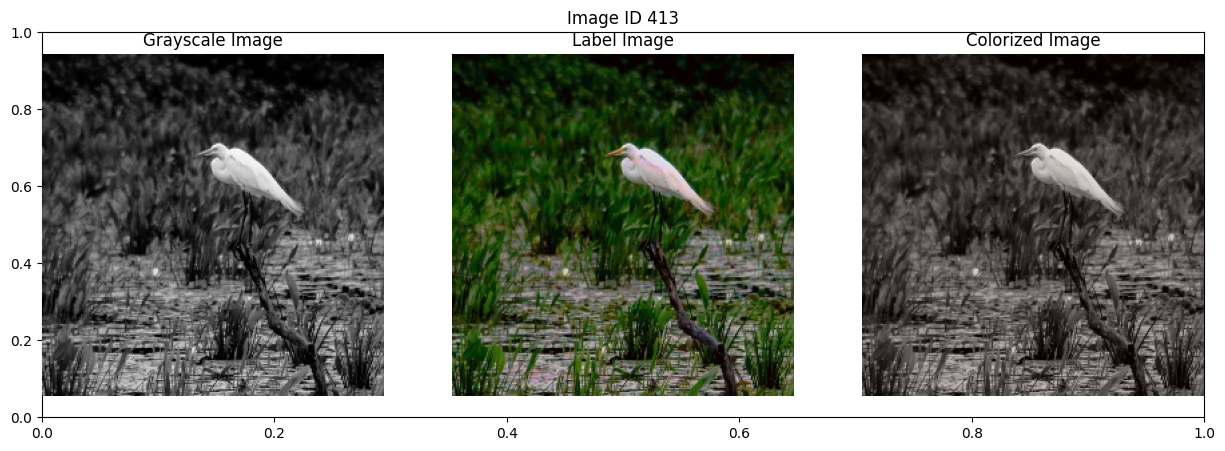

In [69]:
dataset = train_dataset

model.eval()

# Select a random sample
idx = random.randint(0, len(dataset) - 1)
input_l, target = dataset[idx]

# Grayscale
grayscale_image = to_image(input_l)

label_image = combine_l_index_ab(input_l, target, used_ab_pairs)

with torch.no_grad():
    # Forward pass
    input_l = input_l.unsqueeze(0)
    pred_ab_logists = model(input_l)

# convert pred_ab to index

pred_ab_index = torch.argmax(pred_ab_logists[0], dim=0)
print(f'{pred_ab_index.shape=}')

pred_image = combine_l_index_ab(input_l, pred_ab_index, used_ab_pairs)

# print(f'{target.shape=}')
# print(f'{pred_ab.shape=}')

target_ab = convert_index_tensor_to_ab_tensor(target, used_ab_pairs).float()
pred_ab = convert_index_tensor_to_ab_tensor(pred_ab_index, used_ab_pairs).float()



print(f'TARGET MEAN, STD: {target_ab.mean()}, {target_ab.std()}')
print(f'PREDICTED MEAN, STD: {pred_ab.mean()}, {pred_ab.std()}')

# Plot the images
plt.figure(figsize=(15, 5))

plt.title(f'Image ID {idx}')

plt.subplot(1, 3, 1)
plt.title(f"Grayscale Image")
plt.imshow(grayscale_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Label Image")
plt.imshow(label_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Colorized Image")
plt.imshow(pred_image)
plt.axis('off')

plt.show()

<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_178995/3597613754.py:41: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'Label Image $E[ab]: {target.mean():.2f}, \sigma[ab]: {target.std():.2f}$')
/tmp/ipykernel_178995/3597613754.py:46: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'Colorized Image $E[ab]: {pred_ab.mean():.2f}, \sigma[ab]: {pred_ab.std():.2f}$')


  0%|          | 0/7 [00:00<?, ?it/s]

/media/jacek/pliki/uczelnia/12-semestr/gsn/gsn_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2, 256, 256])) that is different to the input size (torch.Size([1, 2, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


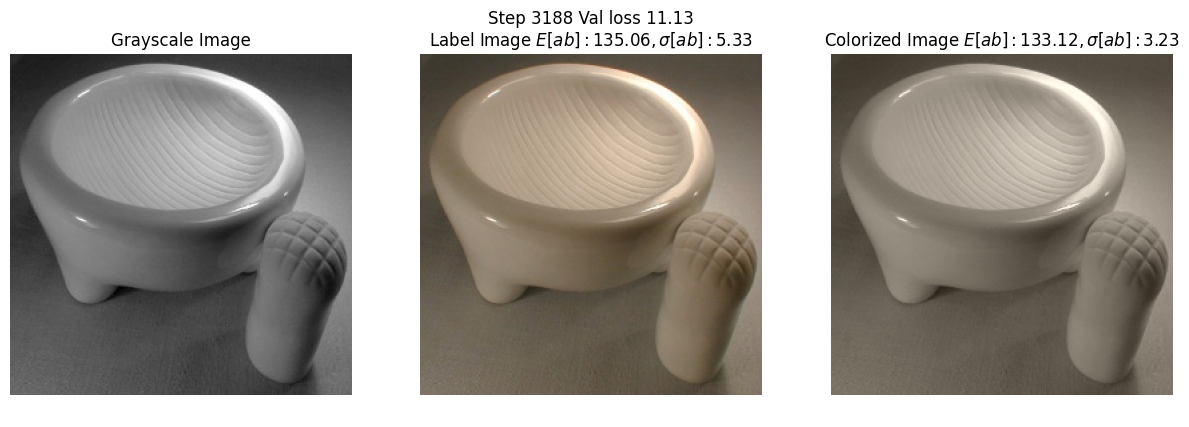

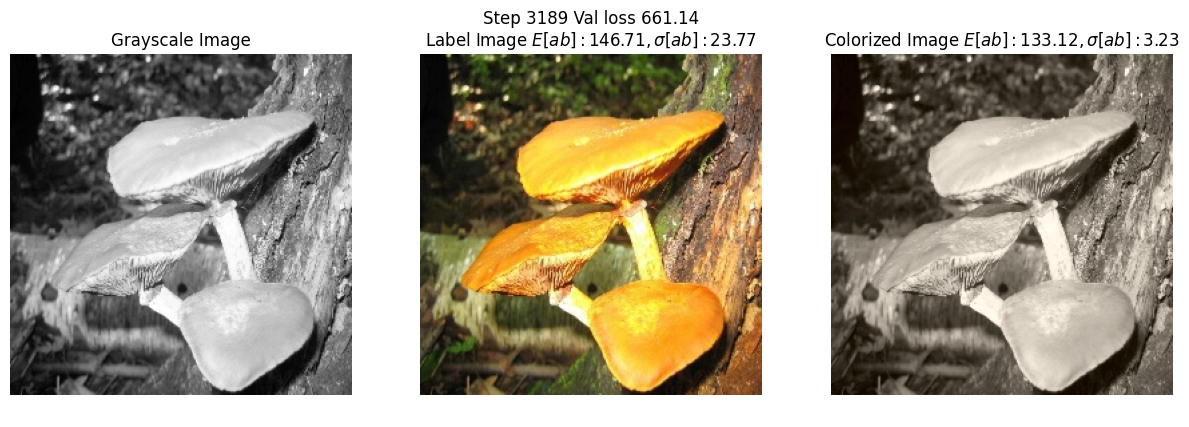

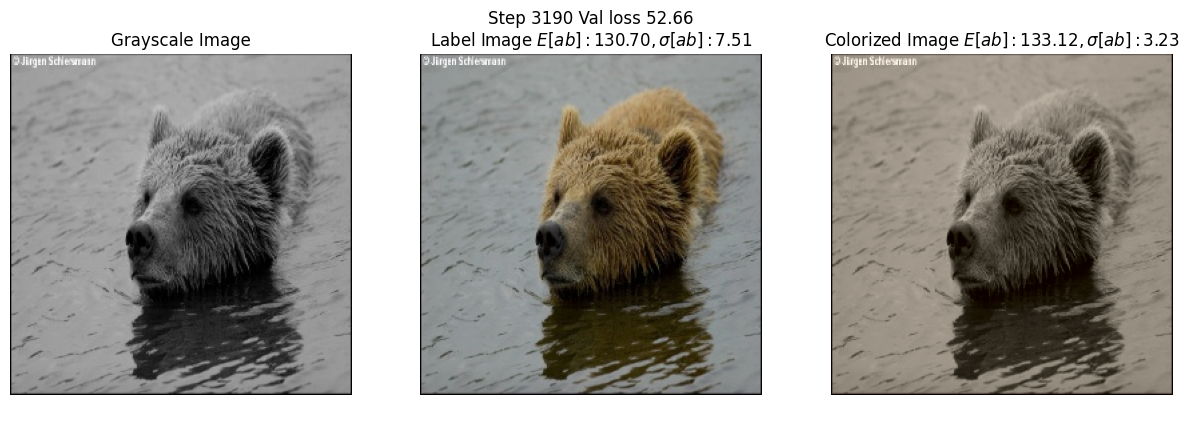

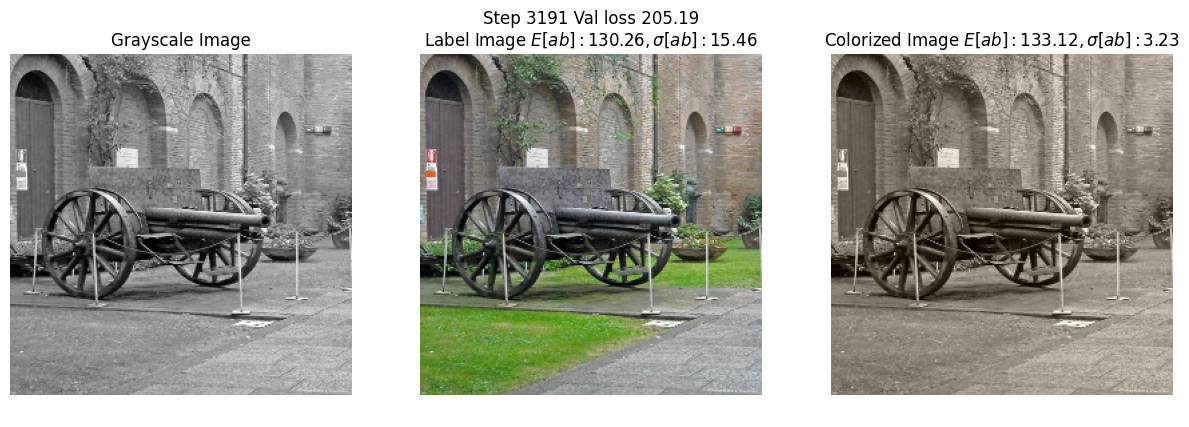

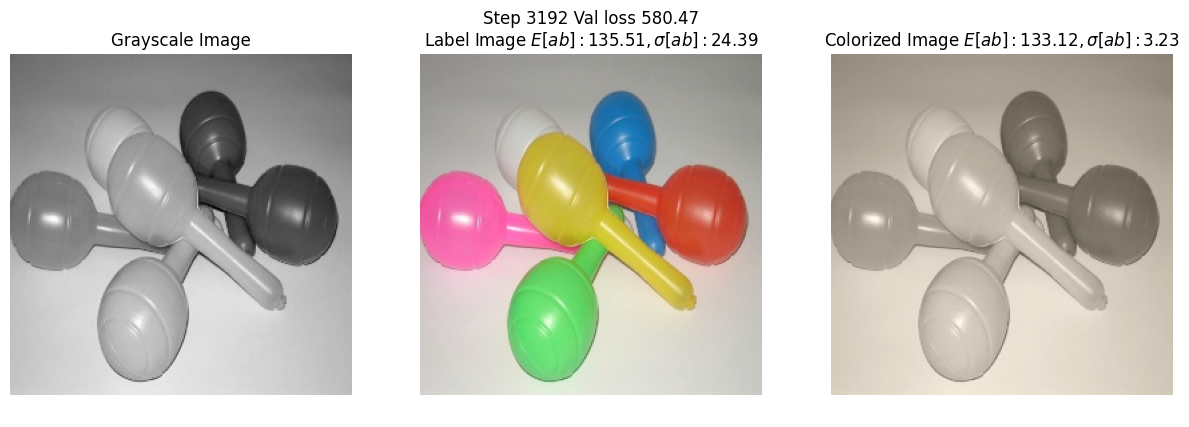

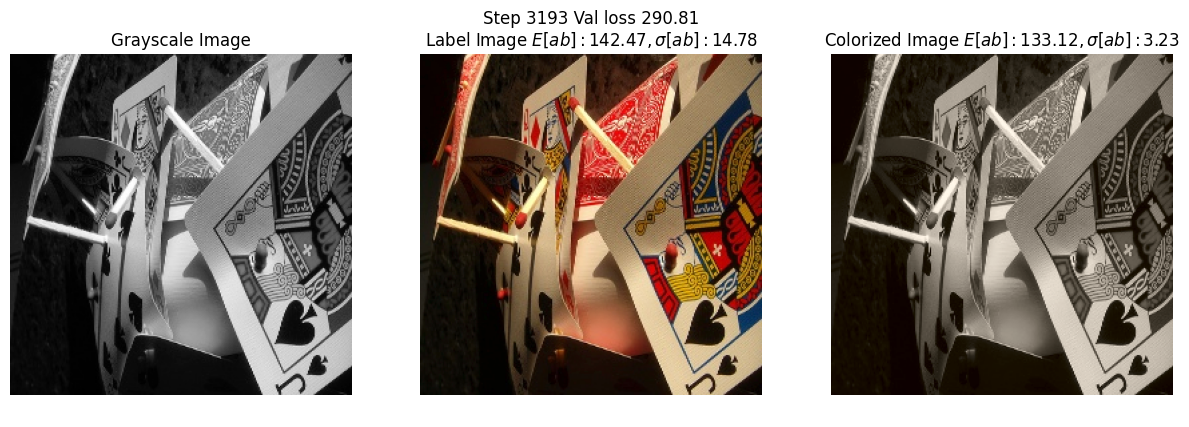

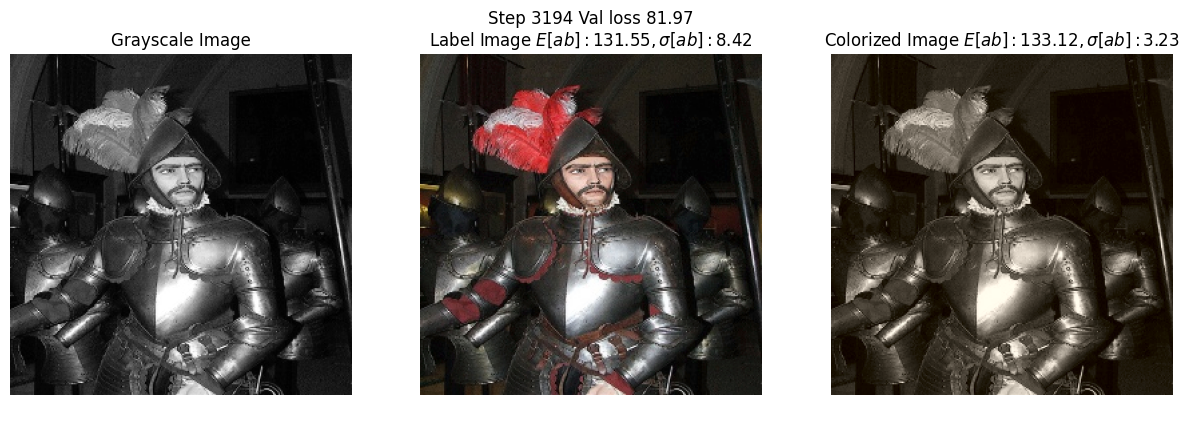

In [57]:
def display_images(dataset, model):
    model.eval()  # Set model to evaluation mode

    # for idx in range(len(dataset)):
    # for idx in range(2):
    for idx in trange(3188,3195):
        input_l, target = dataset[idx]
        # print(target)

        # Grayscale
        grayscale_image = to_image(input_l)

        label_image = combine_l_ab(input_l, target)

        with torch.no_grad():
            # Forward pass
            input_l = input_l.unsqueeze(0)
            pred_ab = model(input_l)


        pred_image = combine_l_ab(input_l, pred_ab)

        loss = model.criterion(pred_ab, target)
        # print(f'Step {idx} Val loss {loss}')

        # print(f'TARGET MEAN, STD: {target.mean()}, {target.std()}')
        # print(f'PREDICTED MEAN, STD: {pred_ab.mean()}, {pred_ab.std()}')

        # Plot the images
        plt.figure(figsize=(15, 5))

        plt.title(f'Step {idx} Val loss {loss:.2f}')
        plt.axis('off')

        plt.subplot(1, 3, 1)
        plt.title(f"Grayscale Image")
        plt.imshow(grayscale_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title(f'Label Image $E[ab]: {target.mean():.2f}, \sigma[ab]: {target.std():.2f}$')
        plt.imshow(label_image)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title(f'Colorized Image $E[ab]: {pred_ab.mean():.2f}, \sigma[ab]: {pred_ab.std():.2f}$')
        plt.imshow(pred_image)
        plt.axis('off')

        # plt.show()
        FIG_PATH = '/home/jacek/uczelnia/12-semestr/gsn/projekt/p4/img/full_results'
        plt.savefig(f'{FIG_PATH}/results_{idx}.png')
display_images(val_dataset, model)

In [38]:
from tqdm.notebook import trange
import pandas as pd

In [55]:
results = []

model.eval()  # Set model to evaluation mode

dataset = val_dataset

# for idx in trange(len(dataset)):
for idx in trange(3188,3195):
    input_l, target = dataset[idx]
    grayscale_image = to_image(input_l)

    label_image = combine_l_ab(input_l, target)

    with torch.no_grad():
        # Forward pass
        input_l = input_l.unsqueeze(0)
        pred_ab = model(input_l)


    pred_image = combine_l_ab(input_l, pred_ab)

    pred_std = pred_ab.std()
    target_std = target.std()
    pred_mean = pred_ab.mean()
    target_mean = target.mean()
    loss = model.criterion(pred_ab, target)

    record = {
        'idx': idx,
        'pred_std': float(pred_std),
        'target_std': float(target_std),
        'pred_mean': float(pred_mean),
        'target_mean': float(target_mean),
        'loss': float(loss),
    }
    results.append(record)

  0%|          | 0/7 [00:00<?, ?it/s]

/media/jacek/pliki/uczelnia/12-semestr/gsn/gsn_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2, 256, 256])) that is different to the input size (torch.Size([1, 2, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [56]:
results_df = pd.DataFrame(results)
results_df

idx  pred_std  target_std   pred_mean  target_mean        loss
0  3188   3.22881    5.327419  133.123901   135.061432   11.127755
1  3189   3.22881   23.766224  133.123901   146.708008  661.144287
2  3190   3.22881    7.513464  133.123901   130.696518   52.660053
3  3191   3.22881   15.458877  133.123901   130.262405  205.192749
4  3192   3.22881   24.389292  133.123901   135.511246  580.469910
5  3193   3.22881   14.775455  133.123901   142.470642  290.805511
6  3194   3.22881    8.415609  133.123901   131.546509   81.965134

In [41]:
# drop col: grayscale_image, label_image, pred_image
results_df.drop(columns=['grayscale_image', 'label_image', 'pred_image'], inplace=True)

In [45]:
# find idx of max_pred_std
max_pred_std_idx = results_df['pred_std'].idxmax()

In [78]:
results = []

model.eval()  # Set model to evaluation mode

dataset = val_dataset

idx = 0
input_l, target = dataset[idx]
grayscale_image = to_image(input_l)

label_image = combine_l_ab(input_l, target)

with torch.no_grad():
    # Forward pass
    input_l = input_l.unsqueeze(0)
    pred_ab = model(input_l)


pred_image = combine_l_ab(input_l, pred_ab)

pred_std = pred_ab.std()
target_std = target.std()
pred_mean = pred_ab.mean()
target_mean = target.mean()
loss = model.criterion(pred_ab, target)

print(f'idx: {idx}')
print(f'pred_std: {pred_std} pred_mean: {pred_mean}')
print(f'target_std: {target_std} target_mean: {target_mean}')

idx: 0
pred_std: 3.2288103103637695 pred_mean: 133.1239013671875
target_std: 7.080543518066406 target_mean: 135.90383911132812


/media/jacek/pliki/uczelnia/12-semestr/gsn/gsn_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2, 256, 256])) that is different to the input size (torch.Size([1, 2, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
